In [2]:
# concatenating files on command line uses: 
# awk 'FNR==1 && NR!=1 {next} {print}' *.csv > combined.csv
# insert *_batter_stats.csv or *_pitcher_stats.csv to combine all csvs

import pandas as pd

pitcher_ratings = pd.read_csv('data/pitcher_ratings.csv')
pitcher_stats = pd.read_csv('data/pitcher_stats.csv')

batter_ratings = pd.read_csv('data/batter_ratings.csv')
batter_stats = pd.read_csv('data/batter_stats.csv')

# realized i needed to iterate through the dataframes to make keys
frames = [pitcher_stats, pitcher_ratings, batter_ratings, batter_stats]

# simple keys made with year and name
for frame in frames:
    frame['Year'] = frame['Year'].astype(str)
    frame['key'] = frame['Year'] + frame['Name']
    frame = frame.dropna(subset='Name', inplace=True)

# trying to merge based on these keys
# merging stats first because some might have gotten injured or didn't meet innings/pa threshold
pitcher = pd.merge(pitcher_stats, pitcher_ratings, on=['key'])
batter = pd.merge(batter_stats, batter_ratings, on=['key'])

In [3]:
# position, stuff, movement, control, stamina, hold
pitcher_ratings_input = ['POS', 'STU', 'MOV', 'CON', 'STM', 'HLD'] 
pitcher_output = ['IP', 'HA', 'HR', 'R', 'ER', 'BB', 'K', 'HP', 'ERA', 'AVG', 'ERA+', 'FIP', 'WAR']

batter_ratings_input = ['CON', 'GAP', 'POW', 'EYE', 'Ks', 'BUN', 'BFH', 'SPE', 'STE']
batter_output = ['PA', 'AB', 'AVG', 'OBP', 'SLG', 'SO', 'ISO', 'OPS', 'OPS+', 'WAR', 'SB', 'CS']

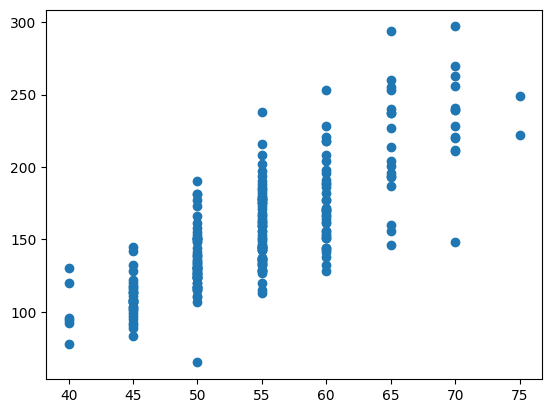

In [47]:
# plotting to see anything interesting
import matplotlib.pyplot as plt

testdf = pitcher[pitcher['IP'] >= 125]
plt.scatter(testdf['STU'], testdf['K'])
plt.show()

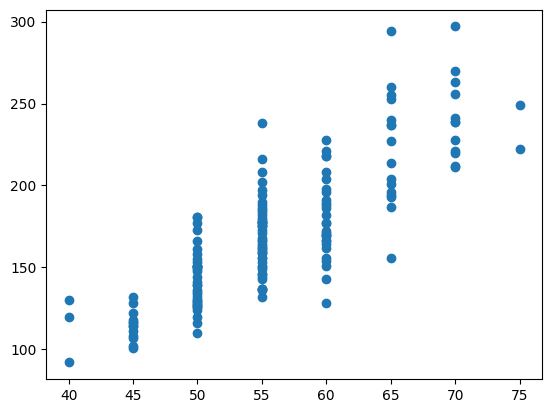

In [50]:
# There are clear outliers no matter the innings we select
import numpy as np

# finding outliers for each value of stuff
for value, group in testdf.groupby('STU'):
    Q1 = group['K'].quantile(0.25)
    Q3 = group['K'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    testdf = testdf.drop(group[(group['K'] < lower_bound) | (group['K'] > upper_bound)].index)

testdf = testdf.reset_index(drop=True)

testdf = testdf[testdf['IP'] >= 150]
plt.scatter(testdf['STU'], testdf['K'])
plt.show()


In [51]:
# Actual model (Pitchers first)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(testdf['STU']).reshape(-1,1)
y = np.array(testdf['K']).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.741749850134753
